In [ ]:
from tensorflow.keras import layers, Model, Input
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
import tensorflow as tf
import cv2
import os
import sys
import random
import numpy as np
import glob
import pandas as pd
from tqdm import tqdm
import tifffile as tif
from PIL import Image
from skimage.io import imread,imshow
from skimage.transform import resize
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda
from keras.models import Model
import zipfile
import tifffile as tiff
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import Model
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.metrics import Precision, Recall

In [ ]:
zip_dir = '/content/drive/MyDrive/DataSet/Shop_DataSet.zip'
zip_ref = zipfile.ZipFile(zip_dir, 'r')
zip_ref.extractall('/content/Shop_DataSet')
zip_ref.close()

In [ ]:
main_dir = '/content/Shop_DataSet/Shop DataSet'
non_shop_lifters_dir = os.path.join(main_dir, 'non shop lifters')
shop_lifters_dir = os.path.join(main_dir, 'shop lifters')

In [ ]:
for dir, dirname, filename in os.walk(non_shop_lifters_dir):
  print(f"Found  {len(filename)} videos in {dir}")

print('-'*100)

for dir, dirname, filename in os.walk(shop_lifters_dir):
  print(f"Found  {len(filename)} videos in {dir}")

Found  531 videos in /content/Shop_DataSet/Shop DataSet/non shop lifters
----------------------------------------------------------------------------------------------------
Found  324 videos in /content/Shop_DataSet/Shop DataSet/shop lifters


In [ ]:
base_path = '/content/Shop_DataSet/Shop DataSet'

# Get all subfolder names
main_dir = os.listdir(base_path)

rooms = []
for item in main_dir:
    folder_path = os.path.join(base_path, item)

    # Only process if it's a directory
    if os.path.isdir(folder_path):
        all_rooms = os.listdir(folder_path)

        for room in all_rooms:
            rooms.append((item, os.path.join(folder_path, room)))

# Build dataframe
train_df = pd.DataFrame(data=rooms, columns=['class','video_name'])
print(train_df.head())
print(train_df.tail())
train_df=train_df.loc[:,['video_name','class']]

          class                                         video_name
0  shop lifters  /content/Shop_DataSet/Shop DataSet/shop lifter...
1  shop lifters  /content/Shop_DataSet/Shop DataSet/shop lifter...
2  shop lifters  /content/Shop_DataSet/Shop DataSet/shop lifter...
3  shop lifters  /content/Shop_DataSet/Shop DataSet/shop lifter...
4  shop lifters  /content/Shop_DataSet/Shop DataSet/shop lifter...
                class                                         video_name
850  non shop lifters  /content/Shop_DataSet/Shop DataSet/non shop li...
851  non shop lifters  /content/Shop_DataSet/Shop DataSet/non shop li...
852  non shop lifters  /content/Shop_DataSet/Shop DataSet/non shop li...
853  non shop lifters  /content/Shop_DataSet/Shop DataSet/non shop li...
854  non shop lifters  /content/Shop_DataSet/Shop DataSet/non shop li...


In [ ]:
train_df

,video_name,class
0,/content/Shop_DataSet/Shop DataSet/shop lifter...,shop lifters
1,/content/Shop_DataSet/Shop DataSet/shop lifter...,shop lifters
2,/content/Shop_DataSet/Shop DataSet/shop lifter...,shop lifters
3,/content/Shop_DataSet/Shop DataSet/shop lifter...,shop lifters
4,/content/Shop_DataSet/Shop DataSet/shop lifter...,shop lifters
...,...,...
850,/content/Shop_DataSet/Shop DataSet/non shop li...,non shop lifters
851,/content/Shop_DataSet/Shop DataSet/non shop li...,non shop lifters
852,/content/Shop_DataSet/Shop DataSet/non shop li...,non shop lifters
853,/content/Shop_DataSet/Shop DataSet/non shop li...,non shop lifters


In [ ]:
IMG_SIZE = 224
MAX_FRAMES = 32

def crop_center_square(frame):
    """قص الفريم من المنتصف ليصبح مربّع"""
    y, x = frame.shape[0:2]
    min_dim = min(y, x)
    start_x = (x // 2) - (min_dim // 2)
    start_y = (y // 2) - (min_dim // 2)
    return frame[start_y:start_y + min_dim, start_x:start_x + min_dim]

def load_video_sampled(path, max_frames=MAX_FRAMES, resize=(IMG_SIZE, IMG_SIZE)):
    cap = cv2.VideoCapture(path)
    frames = []

    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    step = max(1, total_frames // max_frames)  

    try:
        for i in range(total_frames):
            ret, frame = cap.read()
            if not ret:
                break
            if i % step == 0:
                frame = crop_center_square(frame)
                frame = cv2.resize(frame, resize)
                frame = frame[:, :, [2, 1, 0]]  
                frames.append(frame)
                if len(frames) == max_frames:
                    break
    finally:
        cap.release()

    
    while len(frames) < max_frames:
        frames.append(np.zeros((resize[0], resize[1], 3), dtype=np.uint8))

    frames = np.array(frames, dtype=np.float32) / 255.0  

    return frames

In [ ]:
def video_batch_generator(df, batch_size=8):
    num_samples = len(df)
    while True:
        for offset in range(0, num_samples, batch_size):
            batch_df = df.iloc[offset:offset+batch_size]

            batch_videos = []
            batch_labels = []

            for _, row in batch_df.iterrows():
                video_path = row['video_name']
                label = row['class']

                frames_array = load_video_sampled(video_path)
                batch_videos.append(frames_array)
                batch_labels.append(label)

            batch_videos = np.array(batch_videos)
            batch_labels = np.array(batch_labels)

            yield batch_videos, batch_labels

In [ ]:
def build_feature_extractor():
    feature_extractor = InceptionV3(weights="imagenet",include_top=False,pooling="avg",input_shape=(IMG_SIZE, IMG_SIZE, 3),
    )
    preprocess_input = tf.keras.applications.inception_v3.preprocess_input

    inputs = Input((IMG_SIZE, IMG_SIZE, 3))
    preprocessed = preprocess_input(inputs)

    outputs = feature_extractor(preprocessed)
    return Model(inputs, outputs, name="feature_extractor")


feature_extractor = build_feature_extractor()

In [ ]:
label_processor = tf.keras.layers.StringLookup(num_oov_indices=0, vocabulary=np.unique(train_df["class"]))
print(label_processor.get_vocabulary())

labels = train_df["class"].values
labels = label_processor(labels[..., None]).numpy()
labels

[np.str_('non shop lifters'), np.str_('shop lifters')]


array([[1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
    

In [ ]:
#Define hyperparameters

IMG_SIZE = 224
BATCH_SIZE = 64
EPOCHS = 100

MAX_SEQ_LENGTH = 32
NUM_FEATURES = 2048

In [ ]:
def prepare_all_videos(df, root_dir):
    num_samples = len(df)
    video_paths = df["video_name"].values.tolist()

    ##take all classlabels from train_df column named 'tag' and store in labels
    labels = df["class"].values

    #convert classlabels to label encoding
    labels = label_processor(labels[..., None]).numpy()

    # `frame_masks` and `frame_features` are what we will feed to our sequence model.
    # `frame_masks` will contain a bunch of booleans denoting if a timestep is
    # masked with padding or not.
    frame_masks = np.zeros(shape=(num_samples, MAX_SEQ_LENGTH), dtype="bool") # 145,20
    frame_features = np.zeros(shape=(num_samples, MAX_SEQ_LENGTH, NUM_FEATURES), dtype="float32") #145,20,2048

    # For each video.
    for idx, path in enumerate(video_paths):
        # Gather all its frames and add a batch dimension.
        frames = load_video_sampled(os.path.join(root_dir, path))
        frames = frames[None, ...]

        # Initialize placeholders to store the masks and features of the current video.
        temp_frame_mask = np.zeros(shape=(1, MAX_SEQ_LENGTH,), dtype="bool")
        temp_frame_features = np.zeros(
            shape=(1, MAX_SEQ_LENGTH, NUM_FEATURES), dtype="float32"
        )

        # Extract features from the frames of the current video.
        for i, batch in enumerate(frames):
            video_length = batch.shape[0]
            length = min(MAX_SEQ_LENGTH, video_length)
            for j in range(length):
                temp_frame_features[i, j, :] = feature_extractor.predict(
                    batch[None, j, :]
                )
            temp_frame_mask[i, :length] = 1  # 1 = not masked, 0 = masked

        frame_features[idx,] = temp_frame_features.squeeze()
        frame_masks[idx,] = temp_frame_mask.squeeze()

    return (frame_features, frame_masks), labels


train_data, train_labels = prepare_all_videos(train_df, "/content/Shop_DataSet/Shop DataSet")

print(f"Frame features in train set: {train_data[0].shape}")
print(f"Frame masks in train set: {train_data[1].shape}")
print(f"train_labels in train set: {train_labels.shape}")

Streaming output truncated to the last 5000 lines.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step

In [ ]:
print(f"Frame features in train set: {train_data[0].shape}")
print(f"Frame masks in train set: {train_data[1].shape}")
print(f"train_labels in train set: {train_labels.shape}")

Frame features in train set: (855, 32, 2048)
Frame masks in train set: (855, 32)
train_labels in train set: (855, 1)


In [ ]:
# def prepare_all_videos(video_paths, labels):
#     num_samples = len(video_paths)

#     # مصفوفات لتخزين الـ features و الـ masks
#     frame_features = np.zeros(
#         shape=(num_samples, MAX_SEQ_LENGTH, NUM_FEATURES),
#         dtype="float32",
#     )
#     frame_masks = np.zeros(
#         shape=(num_samples, MAX_SEQ_LENGTH),
#         dtype="bool",
#     )

#     for idx, path in enumerate(video_paths):
#         # تحميل الفريمات
#         frames = load_video_sampled(path)  # شكلها (num_frames, IMG_SIZE, IMG_SIZE, 3)

#         # استخراج الـ features لكل فريم
#         temp_frame_features = []
#         for frame in frames:
#             feature_vector = feature_extractor.predict(np.expand_dims(frame, axis=0), verbose=0)
#             temp_frame_features.append(feature_vector[0])

#         # عدد الفريمات الفعلية
#         length = min(len(temp_frame_features), MAX_SEQ_LENGTH)

#         # حفظ النتائج في المصفوفات
#         frame_features[idx, :length] = temp_frame_features[:length]
#         frame_masks[idx, :length] = 1  # الفريمات الحقيقية فقط

#     return frame_features, frame_masks, np.array(labels)


In [ ]:
frame_features, frame_masks = train_data

X_feat_train, X_feat_temp, X_mask_train, X_mask_temp, y_train, y_temp = train_test_split(
    frame_features, frame_masks, train_labels, test_size=0.3, random_state=42
)

X_feat_val, X_feat_test, X_mask_val, X_mask_test, y_val, y_test = train_test_split(
    X_feat_temp, X_mask_temp, y_temp, test_size=0.5, random_state=42
)


X_train = (X_feat_train, X_mask_train)
X_val = (X_feat_val, X_mask_val)
X_test = (X_feat_test, X_mask_test)

print("Train features shape:", X_feat_train.shape)
print("Train masks shape:", X_mask_train.shape)
print("Train labels shape:", y_train.shape)

print("Validation features shape:", X_feat_val.shape)
print("Validation masks shape:", X_mask_val.shape)
print("Validation labels shape:", y_val.shape)

print("Test features shape:", X_feat_test.shape)
print("Test masks shape:", X_mask_test.shape)
print("Test labels shape:", y_test.shape)

Train features shape: (598, 32, 2048)
Train masks shape: (598, 32)
Train labels shape: (598, 1)
Validation features shape: (128, 32, 2048)
Validation masks shape: (128, 32)
Validation labels shape: (128, 1)
Test features shape: (129, 32, 2048)
Test masks shape: (129, 32)
Test labels shape: (129, 1)


In [ ]:
def get_smaller_sequence_model():
    frame_features_input = Input((MAX_SEQ_LENGTH, NUM_FEATURES))
    mask_input = Input((MAX_SEQ_LENGTH,), dtype="bool")

    x = layers.GRU(16, use_cudnn=False)(frame_features_input, mask=mask_input)
    x = layers.Dropout(0.5)(x)
    x = layers.Dense(8, activation="relu")(x)
    x = layers.Dropout(0.5)(x)

    output = layers.Dense(1, activation="sigmoid")(x)

    model = Model([frame_features_input, mask_input], output)

    model.compile(
        loss="binary_crossentropy",
        optimizer="adam",
        metrics=["accuracy", Precision(name="precision"), Recall(name="recall")]
    )
    return model

In [ ]:
train_data = (X_feat_train, X_mask_train)
val_data = (X_feat_val, X_mask_val)
test_data = (X_feat_test, X_mask_test)

train_class = y_train
val_class = y_val
test_class = y_test


In [ ]:
def run_experiment():
    filepath = "/content/sample_data/best_model.weights.h5"
    checkpoint =ModelCheckpoint(filepath, save_weights_only=True, save_best_only=True, verbose=1)
    es = EarlyStopping(monitor='val_loss', mode='min', verbose=3, patience=10)

    seq_model = get_smaller_sequence_model()
    history = seq_model.fit([train_data[0], train_data[1]],train_class,
        validation_data=([val_data[0], val_data[1]], val_class),
        epochs=EPOCHS,
        callbacks=[checkpoint,es],
    )

    seq_model.load_weights(filepath)

    return history, seq_model

In [ ]:
history, sequence_model = run_experiment()

Epoch 1/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step - accuracy: 0.5711 - loss: 0.6985 - precision: 0.4284 - recall: 0.3910
Epoch 1: val_loss improved from inf to 0.65789, saving model to /content/sample_data/best_model.weights.h5
19/19 ━━━━━━━━━━━━━━━━━━━━ 10s 208ms/step - accuracy: 0.5712 - loss: 0.6988 - precision: 0.4284 - recall: 0.3885 - val_accuracy: 0.6250 - val_loss: 0.6579 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/100
18/19 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.5734 - loss: 0.6961 - precision: 0.4448 - recall: 0.3660
Epoch 2: val_loss did not improve from 0.65789
19/19 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - accuracy: 0.5716 - loss: 0.6968 - precision: 0.4410 - recall: 0.3643 - val_accuracy: 0.6250 - val_loss: 0.6655 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/100
18/19 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.5760 - loss: 0.6912 - precision: 0.4362 - recall: 0.3314
Epoch 3: val_loss did not improve from 0.65789
19/19 ━━━━━━━━━

In [ ]:
loss, accuracy, precision, recall = sequence_model.evaluate([test_data[0], test_data[1]], test_class)
print(f"Test loss: {loss:.4f}")
print(f"Test accuracy: {accuracy * 100:.2f}%")
print(f"Test precision: {precision * 100:.2f}%")
print(f"Test recall: {recall * 100:.2f}%")

5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 127ms/step - accuracy: 0.9259 - loss: 0.1873 - precision: 0.8791 - recall: 0.9099
Test loss: 0.1412
Test accuracy: 94.57%
Test precision: 91.67%
Test recall: 93.62%


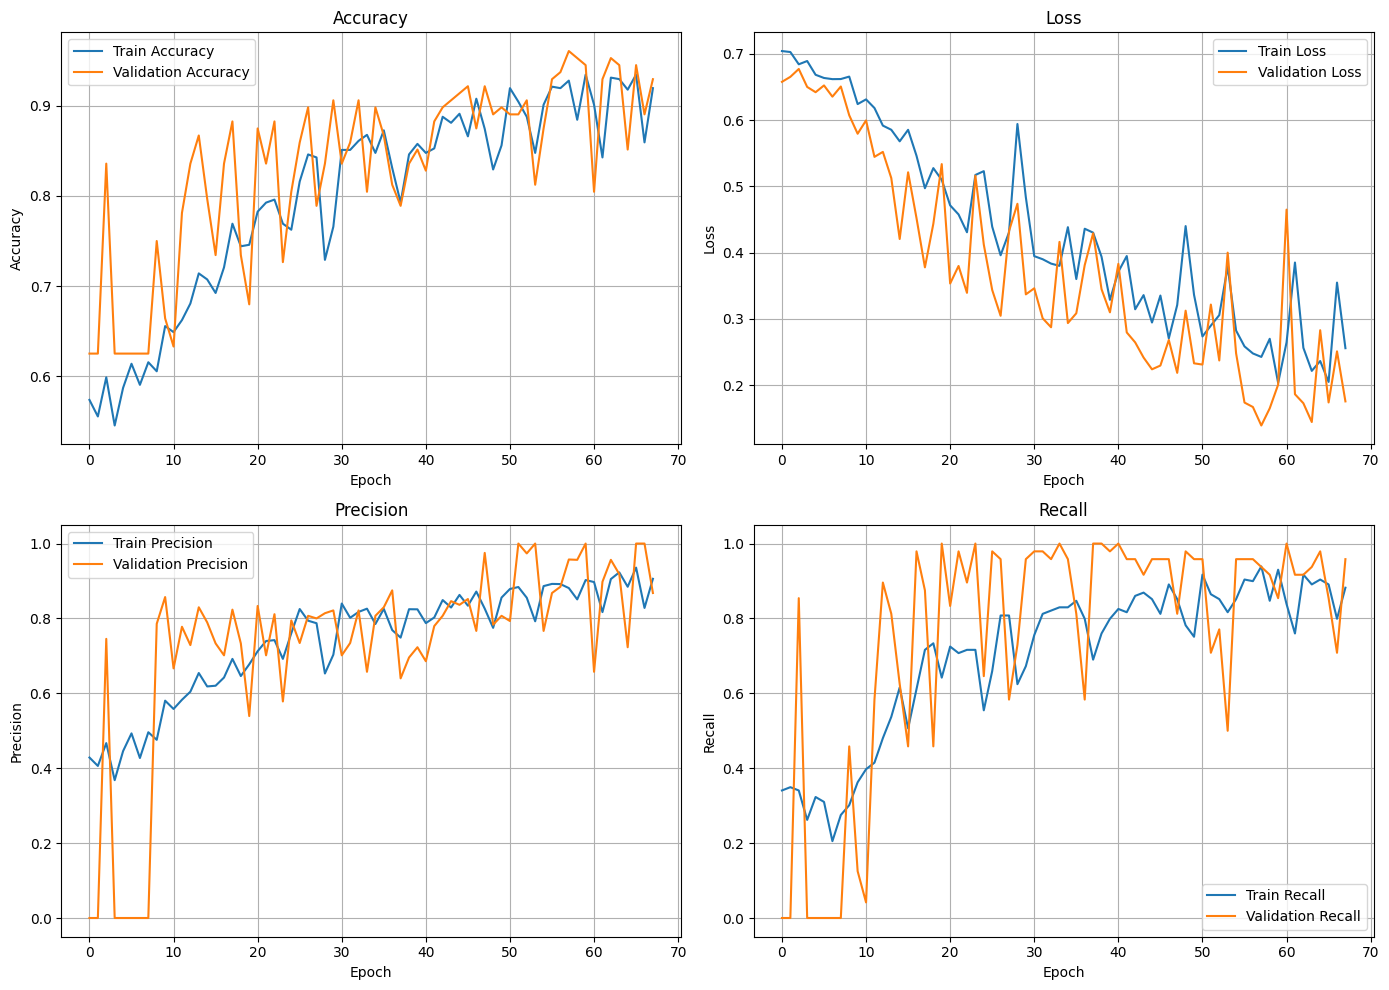

In [ ]:
import matplotlib.pyplot as plt

def plot_metrics(history):
    fig, axs = plt.subplots(2, 2, figsize=(14, 10))

    # Accuracy
    axs[0, 0].plot(history.history['accuracy'], label='Train Accuracy')
    axs[0, 0].plot(history.history['val_accuracy'], label='Validation Accuracy')
    axs[0, 0].set_title('Accuracy')
    axs[0, 0].set_xlabel('Epoch')
    axs[0, 0].set_ylabel('Accuracy')
    axs[0, 0].legend()
    axs[0, 0].grid(True)

    # Loss
    axs[0, 1].plot(history.history['loss'], label='Train Loss')
    axs[0, 1].plot(history.history['val_loss'], label='Validation Loss')
    axs[0, 1].set_title('Loss')
    axs[0, 1].set_xlabel('Epoch')
    axs[0, 1].set_ylabel('Loss')
    axs[0, 1].legend()
    axs[0, 1].grid(True)

    # Precision
    axs[1, 0].plot(history.history['precision'], label='Train Precision')
    axs[1, 0].plot(history.history['val_precision'], label='Validation Precision')
    axs[1, 0].set_title('Precision')
    axs[1, 0].set_xlabel('Epoch')
    axs[1, 0].set_ylabel('Precision')
    axs[1, 0].legend()
    axs[1, 0].grid(True)

    # Recall
    axs[1, 1].plot(history.history['recall'], label='Train Recall')
    axs[1, 1].plot(history.history['val_recall'], label='Validation Recall')
    axs[1, 1].set_title('Recall')
    axs[1, 1].set_xlabel('Epoch')
    axs[1, 1].set_ylabel('Recall')
    axs[1, 1].legend()
    axs[1, 1].grid(True)

    plt.tight_layout()
    plt.show()

# استخدام الدالة مع التاريخ history
plot_metrics(history)
